In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

plt.rcParams.update({"font.size": 14})

In [2]:
ham = hamiltonian_setup(5, [(0, 4), (1, 4), (2, 4), (3, 4)])
ham.hamiltonian

Matrix([
[                               E0,                                 0,                                 0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2],
[                                0,                                E1,                                 0,                                 0, -Ω1*exp(1.0*I*t*ω1)/2],
[                                0,                                 0,                                E2,                                 0, -Ω2*exp(1.0*I*t*ω2)/2],
[                                0,                                 0,                                 0,                                E3, -Ω3*exp(1.0*I*t*ω3)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2, -exp(-1.0*I*t*ω2)*conjugate(Ω2)/2, -exp(-1.0*I*t*ω3)*conjugate(Ω3)/2,                    E4]])

In [3]:
import networkx as nx

In [4]:
np.nonzero(ham.hamiltonian)

(array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 4, 4]),
 array([0, 4, 1, 4, 2, 4, 3, 4, 0, 1, 2, 3, 4]))

In [5]:
graph = nx.Graph()
graph.add_nodes_from(np.unique(np.nonzero(ham.hamiltonian)))
graph.add_edges_from(
    [(idg, ide) for idg, ide in zip(*np.nonzero(ham.hamiltonian)) if idg != ide]
)

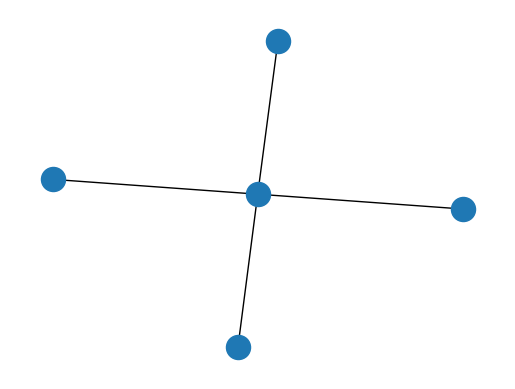

In [6]:
fig, ax = plt.subplots()
nx.draw(graph)

In [7]:
t = smp.Symbol("t", real=True)
T = smp.eye(ham.levels)

for idx in range(ham.levels):
    shortest_path = nx.algorithms.shortest_path(
        graph, source=idx, target=4, weight="weight"
    )
    phase = 0
    for j in range(len(shortest_path) - 1):
        start, stop = shortest_path[j : j + 2]
        if ham.couplings[start, stop] != 0:
            phase += ham.couplings[start, stop]
        else:
            phase -= ham.couplings[stop, start]
    T[idx, idx] = T[idx, idx] * smp.exp(1j * phase * t)

transformed = T.adjoint() @ ham.hamiltonian @ T - 1j * T.adjoint() @ smp.diff(T, t)

smp.simplify(transformed)

Matrix([
[     E0 + 1.0*ω0,                0,                0,                0, -Ω0/2],
[               0,      E1 + 1.0*ω1,                0,                0, -Ω1/2],
[               0,                0,      E2 + 1.0*ω2,                0, -Ω2/2],
[               0,                0,                0,      E3 + 1.0*ω3, -Ω3/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2, -conjugate(Ω2)/2, -conjugate(Ω3)/2,    E4]])

In [8]:
ham.couplings

{(0, 4): ω0, (1, 4): ω1, (2, 4): ω2, (3, 4): ω3}

In [9]:
ham = Hamiltonian(levels=5)
for idc, coupling in enumerate([(0, 4), (1, 4), (2, 4), (3, 4), (1, 2), (2, 3)]):
    rabi = smp.Symbol(f"Ω{idc}", complex=True)
    omega = smp.Symbol(f"ω{idc}", real=True)
    ham.add_coupling(*coupling, rabi, omega)

In [10]:
ham.hamiltonian

Matrix([
[                               E0,                                 0,                                 0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2],
[                                0,                                E1,             -Ω4*exp(1.0*I*t*ω4)/2,                                 0, -Ω1*exp(1.0*I*t*ω1)/2],
[                                0, -exp(-1.0*I*t*ω4)*conjugate(Ω4)/2,                                E2,             -Ω5*exp(1.0*I*t*ω5)/2, -Ω2*exp(1.0*I*t*ω2)/2],
[                                0,                                 0, -exp(-1.0*I*t*ω5)*conjugate(Ω5)/2,                                E3, -Ω3*exp(1.0*I*t*ω3)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2, -exp(-1.0*I*t*ω2)*conjugate(Ω2)/2, -exp(-1.0*I*t*ω3)*conjugate(Ω3)/2,                    E4]])

In [11]:
graph = nx.Graph()
graph.add_nodes_from(np.unique(np.nonzero(ham.hamiltonian)))
graph.add_edges_from(
    [(idg, ide) for idg, ide in zip(*np.nonzero(ham.hamiltonian)) if idg != ide]
)

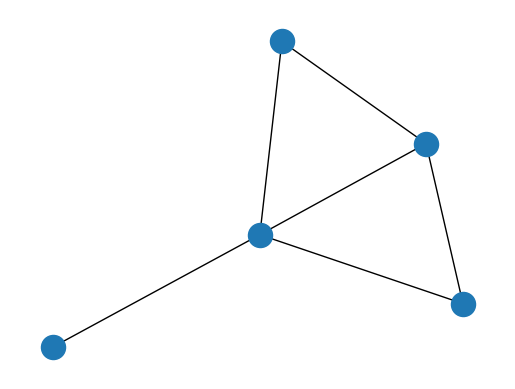

In [12]:
fig, ax = plt.subplots()
nx.draw(graph)

In [13]:
t = smp.Symbol("t", real=True)
T = smp.eye(ham.levels)

for idx in range(ham.levels):
    shortest_path = nx.algorithms.shortest_path(
        graph, source=idx, target=4, weight="weight"
    )
    phase = 0
    for j in range(len(shortest_path) - 1):
        start, stop = shortest_path[j : j + 2]
        if ham.couplings[start, stop] != 0:
            phase += ham.couplings[start, stop]
        else:
            phase -= ham.couplings[stop, start]
    T[idx, idx] = T[idx, idx] * smp.exp(1j * phase * t)

transformed = T.adjoint() @ ham.hamiltonian @ T - 1j * T.adjoint() @ smp.diff(T, t)
transformed = smp.simplify(transformed)
ham.transformed = transformed
smp.nsimplify(ham.transformed)

Matrix([
[         E0 + ω0,                                          0,                                          0,                              0, -Ω0/2],
[               0,                                    E1 + ω1,             -Ω4*exp(I*t*(-ω1 + ω2 + ω4))/2,                              0, -Ω1/2],
[               0, -exp(-I*t*(-ω1 + ω2 + ω4))*conjugate(Ω4)/2,                                    E2 + ω2, -Ω5*exp(I*t*(-ω2 + ω3 + ω5))/2, -Ω2/2],
[               0,                                          0, -exp(-I*t*(-ω2 + ω3 + ω5))*conjugate(Ω5)/2,                        E3 + ω3, -Ω3/2],
[-conjugate(Ω0)/2,                           -conjugate(Ω1)/2,                           -conjugate(Ω2)/2,               -conjugate(Ω3)/2,    E4]])

In [14]:
ham.setup_detunings()
ham.transformed

Matrix([
[ 1.0*E4 - 1.0*δ0,                                             0,                                             0,                                 0, -Ω0/2],
[               0,                               1.0*E4 - 1.0*δ1,             -Ω4*exp(1.0*I*t*(δ1 - δ2 - δ4))/2,                                 0, -Ω1/2],
[               0, -exp(-1.0*I*t*(δ1 - δ2 - δ4))*conjugate(Ω4)/2,                               1.0*E4 - 1.0*δ2, -Ω5*exp(1.0*I*t*(δ2 - δ3 - δ5))/2, -Ω2/2],
[               0,                                             0, -exp(-1.0*I*t*(δ2 - δ3 - δ5))*conjugate(Ω5)/2,                   1.0*E4 - 1.0*δ3, -Ω3/2],
[-conjugate(Ω0)/2,                              -conjugate(Ω1)/2,                              -conjugate(Ω2)/2,                  -conjugate(Ω3)/2,    E4]])

In [15]:
ham.remove_common_energy()
ham.transformed = smp.nsimplify(ham.transformed)
ham.transformed

Matrix([
[             -δ0,                                         0,                                         0,                             0, -Ω0/2],
[               0,                                       -δ1,             -Ω4*exp(I*t*(δ1 - δ2 - δ4))/2,                             0, -Ω1/2],
[               0, -exp(-I*t*(δ1 - δ2 - δ4))*conjugate(Ω4)/2,                                       -δ2, -Ω5*exp(I*t*(δ2 - δ3 - δ5))/2, -Ω2/2],
[               0,                                         0, -exp(-I*t*(δ2 - δ3 - δ5))*conjugate(Ω5)/2,                           -δ3, -Ω3/2],
[-conjugate(Ω0)/2,                          -conjugate(Ω1)/2,                          -conjugate(Ω2)/2,              -conjugate(Ω3)/2,     0]])